In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

In [2]:
#set director for images
image_train = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train2')
image_train1= Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train')

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'csv'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfplume = pd.read_csv("plume_attribution_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfplume.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN


In [5]:
dfplume.shape

(8752, 13)

In [6]:
# Filter plume data for data after June 2020
dfplumef = dfplume[dfplume['date'] >= '2020-06-01']

In [7]:
dfplumef.shape

(5685, 13)

In [8]:
dfplumef.nunique()

Unnamed: 0           5685
source_id            2463
candidate_id         4225
plume_lat            4177
plume_lon            4037
date                  407
source_type            16
ipcc                    9
qplume               4221
sigma_qplume         4221
time_of_detection     221
plume_tif             534
rgb_tif               534
dtype: int64

In [9]:
dfsource = pd.read_csv("source_list_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfsource.head()

,Unnamed: 0,source_id,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,source_type,confidence_in_persistence
0,0,G0001,35.249160,-119.57875,7,0.142857,96.853478,33.082042,tank,high
1,1,G0002,35.082251,-119.30443,7,0.142857,5.364176,1.441589,compressor,low
2,2,G0003,35.367999,-119.68495,7,0.857143,187.200884,79.748988,pipeline,high
3,3,G0004,35.343365,-119.64244,7,0.285714,44.889285,24.739863,pipeline,high
4,4,G0005,35.359342,-119.66100,7,1.000000,880.375832,244.909184,pipeline,high


In [10]:
dfsource.shape

(4199, 10)

In [11]:
filepaths = pd.Series(list(image_train.glob(r'**/*.png')), name='Filepath').astype(str)

In [12]:
df_filepaths = filepaths.to_frame()

In [13]:
res = os.listdir(image_train)
df_filepaths['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [14]:
df_filepaths['candidate_id'] = [x.split('_')[-0] for x in df_filepaths['Name']]

In [15]:
df_filepaths.head()

,Filepath,Name,candidate_id
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t192518-3_r1823_c108-plume.png,ang20200708t192518-3
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-1_r4784_c237-plume.png,ang20200708t200101-1
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-A_r502_c-24-plume.png,ang20200708t200101-A
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-B_r3756_c132-plume.png,ang20200708t200101-B
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200905-1_r1236_c363-plume.png,ang20200708t200905-1


In [16]:
df_filepaths.nunique()

Filepath        3059
Name            3059
candidate_id    3059
dtype: int64

In [17]:
dfplumef['candidate_id2'] = [x.split('-')[-0] for x in dfplumef['candidate_id']]

In [18]:
dfplumef.nunique()

Unnamed: 0           5685
source_id            2463
candidate_id         4225
plume_lat            4177
plume_lon            4037
date                  407
source_type            16
ipcc                    9
qplume               4221
sigma_qplume         4221
time_of_detection     221
plume_tif             534
rgb_tif               534
candidate_id2        1625
dtype: int64

In [19]:
df_filepaths.to_excel("filepaths.xlsx")  

In [20]:
dfplumef.to_excel("dfplumef.xlsx")  

In [21]:
dup = dfplumef[dfplumef['candidate_id'].duplicated() == True]

In [22]:
dup.to_excel("dup.xlsx")  

In [23]:
dup.shape

(1460, 14)

In [24]:
5685-4225

1460

In [25]:
#drop duplicates
dfplumef = dfplumef.drop_duplicates(subset='candidate_id', keep="first")

In [26]:
dfplumef.nunique()

Unnamed: 0           4225
source_id            2463
candidate_id         4225
plume_lat            4177
plume_lon            4037
date                  184
source_type            16
ipcc                    9
qplume               4221
sigma_qplume         4221
time_of_detection     221
plume_tif              61
rgb_tif                61
candidate_id2        1625
dtype: int64

In [27]:
dfdata = pd.merge(df_filepaths,dfplumef, on='candidate_id')

In [28]:
dfdata.shape

(3058, 16)

In [29]:
dfdata.to_excel("dfdata.xlsx")  

In [30]:
dfdata=dfdata.dropna(subset=["qplume"])

In [31]:
dfsource.nunique()

Unnamed: 0                   4199
source_id                    4199
source_lat                   4196
source_lon                   4167
number_overflights             14
source_persistence             53
qsource                      4198
sigma_qsource                4198
source_type                    17
confidence_in_persistence      10
dtype: int64

In [32]:
dfdata2 = pd.merge(dfsource,dfdata, on='source_id')

In [33]:
dfdata2.shape

(2995, 25)

In [34]:
dfdata2.nunique()

Unnamed: 0_x                 1770
source_id                    1770
source_lat                   1769
source_lon                   1765
number_overflights             12
source_persistence             36
qsource                      1770
sigma_qsource                1770
source_type_x                  16
confidence_in_persistence      10
Filepath                     2995
Name                         2995
candidate_id                 2995
Unnamed: 0_y                 2995
plume_lat                    2968
plume_lon                    2886
date                          111
source_type_y                  16
ipcc                            7
qplume                       2994
sigma_qplume                 2994
time_of_detection             219
plume_tif                       0
rgb_tif                         0
candidate_id2                1134
dtype: int64

In [35]:
dfdata2 = dfdata2.drop(columns=['plume_tif', 'rgb_tif'])

In [37]:
dfdata2['Uncern'] = (dfdata2.sigma_qplume/dfdata2.qplume)*100

In [38]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfplumeper = pd.read_csv("permian_plume_list_2019 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfplumeper.head()

,Unnamed: 0,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected
0,0,P00001,32.212063,-103.697076,ang20190922t192642-2,2019-09-22,19:26:42,2579.528100,902.732655,False,False
1,1,P00002,32.200072,-103.673301,ang20190922t192642-4,2019-09-22,19:26:42,420.725207,147.155782,False,False
2,2,P00003,32.116008,-103.626345,ang20190922t192642-5,2019-09-22,19:26:42,1051.909600,339.267587,False,False
3,3,P00004,32.322594,-103.816072,ang20190922t194340-1,2019-09-22,19:43:40,1736.644250,1035.427670,False,False
4,4,P00005,32.284083,-103.793989,ang20190922t194340-2,2019-09-22,19:43:40,870.605019,435.968147,False,False


In [39]:
dfplumeper.shape

(3067, 11)

In [40]:
dfplumeper.nunique()

Unnamed: 0                 3067
source_id                  1756
plume_lat                  3061
plume_lon                  3058
candidate_id               3067
date                         31
time                        552
qplume                     3066
sigma_qplume               3066
active_flair_detected         2
inactive_flair_detected       2
dtype: int64

In [41]:
dfsourceper = pd.read_csv("permian_source_list_2019 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfsourceper.head()

,Unnamed: 0,source_id,source_lat,source_lon,type,ipcc_sector,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource
0,0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.484230,307.380288
1,1,P00002,32.199937,-103.673324,tank,1B2 Oil & Natural Gas,12,0.333333,0.968324,207.089504,47.441634
2,2,P00003,32.116135,-103.626582,tank,1B2 Oil & Natural Gas,12,0.583333,0.968324,305.700650,97.254972
3,3,P00004,32.322594,-103.816072,pipeline,1B2 Oil & Natural Gas,11,0.090909,0.957765,157.876750,94.129788
4,4,P00005,32.284279,-103.793918,tank,1B2 Oil & Natural Gas,10,0.200000,0.943686,161.404695,51.069466


In [42]:
dfsourceper.shape

(1756, 11)

In [43]:
dfsourceper.nunique()

Unnamed: 0                   1756
source_id                    1756
source_lat                   1756
source_lon                   1756
type                            5
ipcc_sector                     1
number_overflights             14
source_persistence             46
confidence_in_persistence      14
qsource                      1756
sigma_qsource                1756
dtype: int64

In [44]:
filepaths1 = pd.Series(list(image_train1.glob(r'**/*.png')), name='Filepath').astype(str)

In [45]:
df_filepaths1 = filepaths1.to_frame()

In [46]:
res = os.listdir(image_train1)
df_filepaths1['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [47]:
df_filepaths1['candidate_id'] = [x.split('_')[-0] for x in df_filepaths1['Name']]

In [48]:
df_filepaths1.head()

,Filepath,Name,candidate_id
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-4_r4928_c373-plume.png,ang20190922t192642-4
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-5_r6423_c113-plume.png,ang20190922t192642-5
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-A_r3270_c384-plume.png,ang20190922t192642-A
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-B_r4034_c360-plume.png,ang20190922t192642-B


In [49]:
df_filepaths1.nunique()

Filepath        3763
Name            3763
candidate_id    3311
dtype: int64

In [50]:
dup1 = dfplumeper[dfplumeper['candidate_id'].duplicated() == True]

In [51]:
dup1.shape

(0, 11)

In [52]:
dfdataper = pd.merge(df_filepaths1,dfplumeper, on='candidate_id')

In [53]:
dfdataper.shape

(3067, 13)

In [54]:
dfdataper.nunique()

Filepath                   3067
Name                       3067
candidate_id               3067
Unnamed: 0                 3067
source_id                  1756
plume_lat                  3061
plume_lon                  3058
date                         31
time                        552
qplume                     3066
sigma_qplume               3066
active_flair_detected         2
inactive_flair_detected       2
dtype: int64

In [55]:
dfdataper2 = pd.merge(dfsourceper,dfdataper, on='source_id')

In [56]:
dfdataper2.shape

(3067, 23)

In [57]:
dfdataper2.nunique()

Unnamed: 0_x                 1756
source_id                    1756
source_lat                   1756
source_lon                   1756
type                            5
ipcc_sector                     1
number_overflights             14
source_persistence             46
confidence_in_persistence      14
qsource                      1756
sigma_qsource                1756
Filepath                     3067
Name                         3067
candidate_id                 3067
Unnamed: 0_y                 3067
plume_lat                    3061
plume_lon                    3058
date                           31
time                          552
qplume                       3066
sigma_qplume                 3066
active_flair_detected           2
inactive_flair_detected         2
dtype: int64

In [61]:
dfdataper2['Uncern'] = (dfdataper2.sigma_qplume/dfdata2.qplume)*100

In [62]:
dfdata2.shape

(2995, 24)

In [63]:
dfdataper2.shape

(3067, 24)

In [64]:
dfdata2.nunique()

Unnamed: 0_x                 1770
source_id                    1770
source_lat                   1769
source_lon                   1765
number_overflights             12
source_persistence             36
qsource                      1770
sigma_qsource                1770
source_type_x                  16
confidence_in_persistence      10
Filepath                     2995
Name                         2995
candidate_id                 2995
Unnamed: 0_y                 2995
plume_lat                    2968
plume_lon                    2886
date                          111
source_type_y                  16
ipcc                            7
qplume                       2994
sigma_qplume                 2994
time_of_detection             219
candidate_id2                1134
Uncern                       2994
dtype: int64

In [65]:
dfdata2 = dfdata2.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','time_of_detection','candidate_id2'])

In [67]:
dfdata2 = dfdata2.drop(columns=['source_type_x'])

In [68]:
dfdataper2.nunique()

Unnamed: 0_x                 1756
source_id                    1756
source_lat                   1756
source_lon                   1756
type                            5
ipcc_sector                     1
number_overflights             14
source_persistence             46
confidence_in_persistence      14
qsource                      1756
sigma_qsource                1756
Filepath                     3067
Name                         3067
candidate_id                 3067
Unnamed: 0_y                 3067
plume_lat                    3061
plume_lon                    3058
date                           31
time                          552
qplume                       3066
sigma_qplume                 3066
active_flair_detected           2
inactive_flair_detected         2
Uncern                       2995
dtype: int64

In [69]:
dfdataper2 = dfdataper2.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','active_flair_detected','time'])

In [70]:
dfdataper2 = dfdataper2.drop(columns=['inactive_flair_detected'])

In [71]:
dfdataper2 = dfdataper2.rename(columns={'type': 'source_type_y', 'ipcc_sector': 'ipcc'})

In [72]:
data = pd.concat([dfdataper2, dfdata2])

In [73]:
data.shape

(6062, 19)

In [74]:
data.nunique()

source_id                    3526
source_lat                   3524
source_lon                   3517
source_type_y                  16
ipcc                            7
number_overflights             14
source_persistence             68
confidence_in_persistence      24
qsource                      3526
sigma_qsource                3526
Filepath                     6062
Name                         6062
candidate_id                 6062
plume_lat                    6027
plume_lon                    5929
date                          142
qplume                       6060
sigma_qplume                 6060
Uncern                       5989
dtype: int64

In [75]:
datamodel = data

In [76]:
datamodel.shape

(6062, 19)

In [82]:
def image_processing(fil):
    # Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
        
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    
    mask2 = np.dstack((red,green,blue))
    
    arr = np.array(mask2)
    
    mask = np.where(arr != 0)
    
    avg = np.mean(arr[mask])
    
#    flat_red = red.flatten()
#    flat_green = green.flatten()
#    flat_blue = blue.flatten()
    
#    nonzero_red = flat_red[flat_red != 0]
#    nonzero_green = flat_green[flat_green != 0]
#    nonzero_blue = flat_blue[flat_blue != 0]
    
#    meanr = np.mean(nonzero_red)
#    meang = np.mean(nonzero_green)
#    meanb = np.mean(nonzero_blue)
    
#    filename = fil.split("/")[-1]
    
    return avg

In [83]:
pic_list = []
name_list = []
#qplume = []

In [84]:
for file in tqdm(datamodel['Filepath'].tolist()[:]):
    avg = image_processing(file)
    pic_list.append(avg)
    name_list.append(os.path.basename(file))  # add filename to list

100%|██████████| 6062/6062 [01:45<00:00, 57.63it/s]


In [85]:
dfeat = pd.DataFrame({'pic_val': pic_list, 'Name': name_list})

In [86]:
dfeat.head()

,pic_val,Name
0,114.139838,ang20190922t192642-2_r4578_c217-plume.png
1,125.558812,ang20190923t163307-G_r4113_c198-plume.png
2,106.232057,ang20190926t223557-D_r4139_c225-plume.png
3,155.931577,ang20191006t150453-6_r4168_c237-plume.png
4,138.265995,ang20191007t182352-2_r4062_c150-plume.png


In [119]:
dfeat3 = pd.merge(dfeat, datamodel, on='Name')

In [120]:
dfeat3.head()

,pic_val,Name,source_id,source_lat,source_lon,source_type_y,ipcc,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource,Filepath,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,Uncern
0,114.139838,ang20190922t192642-2_r4578_c217-plume.png,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2,32.212063,-103.697076,2019-09-22,2579.528100,902.732655,133.151448
1,125.558812,ang20190923t163307-G_r4113_c198-plume.png,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190923t163307-G,32.212117,-103.697086,2019-09-23,934.430300,276.716131,736.942230
2,106.232057,ang20190926t223557-D_r4139_c225-plume.png,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190926t223557-D,32.212162,-103.696830,2019-09-26,443.098484,152.257940,110.191596
3,155.931577,ang20191006t150453-6_r4168_c237-plume.png,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191006t150453-6,32.212327,-103.697526,2019-10-06,1032.395030,606.623335,244.327697
4,138.265995,ang20191007t182352-2_r4062_c150-plume.png,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191007t182352-2,32.212253,-103.697253,2019-10-07,826.823256,226.851094,135.781536


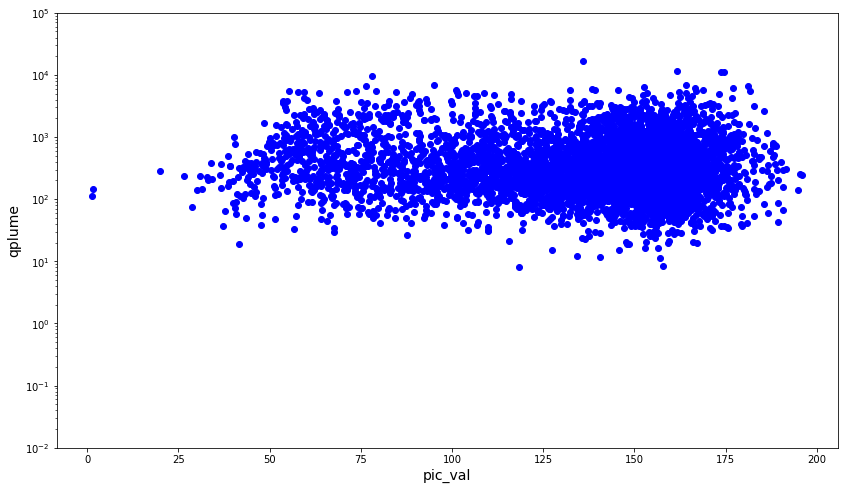

In [129]:
# Generate values for missing permeability values as a function of porosity
a = dfeat3['pic_val']
b = dfeat3['qplume']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
#plt.scatter(a, b1, color='orange')
plt.xlabel("pic_val", size=14)
plt.ylabel("qplume", size=14)
plt.yscale('log', nonposy='clip')
#plt.xlim([0.01, 100000])
#plt.xscale('log', nonposx='clip')
plt.ylim([0.01, 100000])
#plt.gca().invert_yaxis()



#plt.tight_layout()
plt.show()

In [122]:
dfeat3.isna().sum()

pic_val                       2
Name                          0
source_id                     0
source_lat                    0
source_lon                    0
source_type_y                58
ipcc                         12
number_overflights            0
source_persistence            0
confidence_in_persistence     0
qsource                       0
sigma_qsource                 0
Filepath                      0
candidate_id                  0
plume_lat                     0
plume_lon                     0
date                          0
qplume                        0
sigma_qplume                  0
Uncern                       72
dtype: int64

In [123]:
(dfeat3.eq(0)).sum()

pic_val                      0
Name                         0
source_id                    0
source_lat                   0
source_lon                   0
source_type_y                0
ipcc                         0
number_overflights           0
source_persistence           0
confidence_in_persistence    0
qsource                      0
sigma_qsource                0
Filepath                     0
candidate_id                 0
plume_lat                    0
plume_lon                    0
date                         0
qplume                       0
sigma_qplume                 0
Uncern                       0
dtype: int64

In [125]:
dfeat3.drop(dfeat3[dfeat3['pic_val'] == 0].index, inplace=True)

In [126]:
#dfeat3 = dfeat3.pic_val.dropna()

In [127]:
dfeat3.shape

(6062, 20)

In [128]:
dfeat3.to_excel("dfeat3all.xlsx")

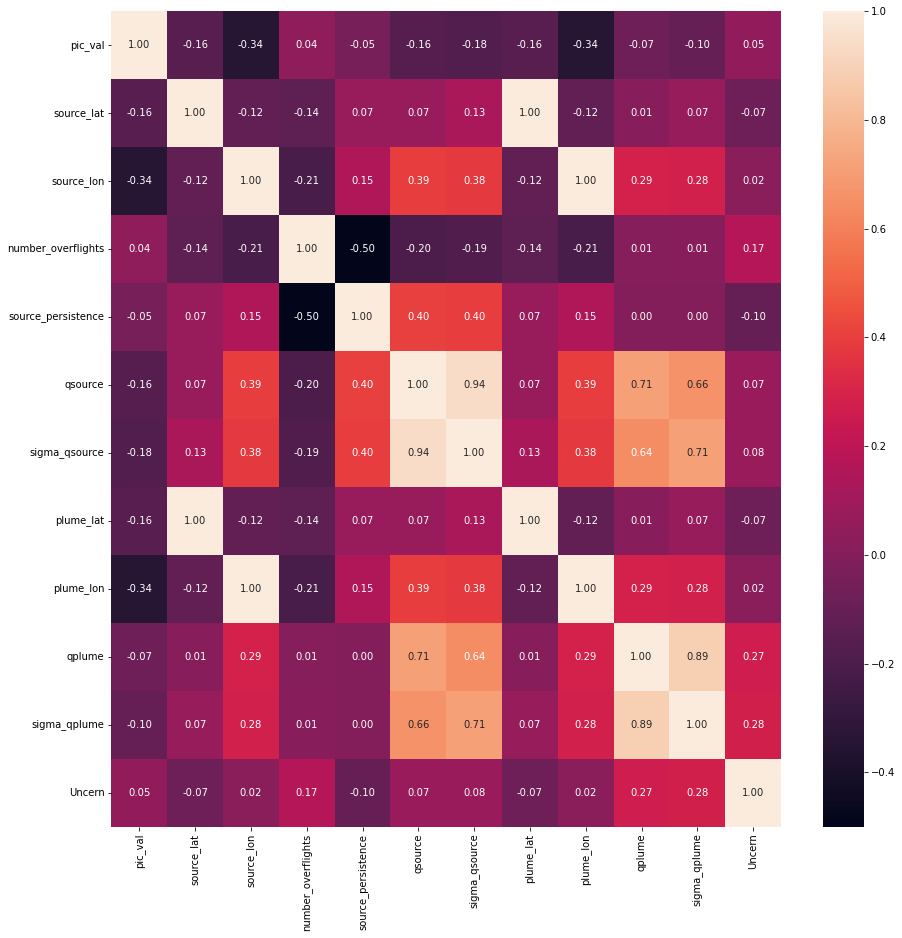

In [101]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(dfeat3.corr(), annot=True, fmt=".2f")

In [115]:
dfeat3.shape

(6060, 3)

In [102]:
image_sub = []

In [103]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [104]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [105]:
df_testpaths = testpaths.to_frame()

In [106]:
pic_list1 = []
name_list1 = []
#qplume = []

In [107]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    avg = image_processing(file)
    pic_list1.append(avg)
    name_list1.append(os.path.basename(file))  # add filename to list

100%|██████████| 20/20 [00:00<00:00, 107.12it/s]


In [108]:
dsub = pd.DataFrame({'pic_val': pic_list1, 'Name': name_list1})
#dsub = pd.DataFrame({'Red': meanr_list1, 'Green': meang_list1, 'Blue': meanb_list1, 'Name': name_list1})

In [109]:
dsub

,pic_val,Name
0,126.834570,01A.png
1,134.068051,02A.png
2,139.087957,03A.png
3,136.115646,04A.png
4,134.872976,05A.png
5,136.441601,06A.png
6,129.841780,07A.png
7,135.147339,08A.png
8,132.081186,09A.png
9,128.553614,10A.png


In [145]:
dsub['log_pic_val'] = np.log(dsub['pic_val'])

In [144]:
dsub = dsub.drop('Name', axis=1)

In [147]:
dsub = dsub.drop('pic_val', axis=1)

In [110]:
dsub.to_excel("dsub.xlsx")  

In [149]:
dsub.shape

(20, 1)